# Generative Adversarial Networks

# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision.utils import make_grid, save_image

# Load Data

In [3]:
train_dataset = MNIST('/nas/dataset/MNIST', train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((32, 32)),
        ]))

In [4]:
def plot_image_grid(data, nRow, nCol, filename=None):

    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))
    
    data = data.detach().cpu()

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            image   = np.squeeze(data[k], axis=0)

            axes[i, j].imshow(image, cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)
            

    plt.show()
    
    if filename is not None:

        fig.savefig(filename)
        pass

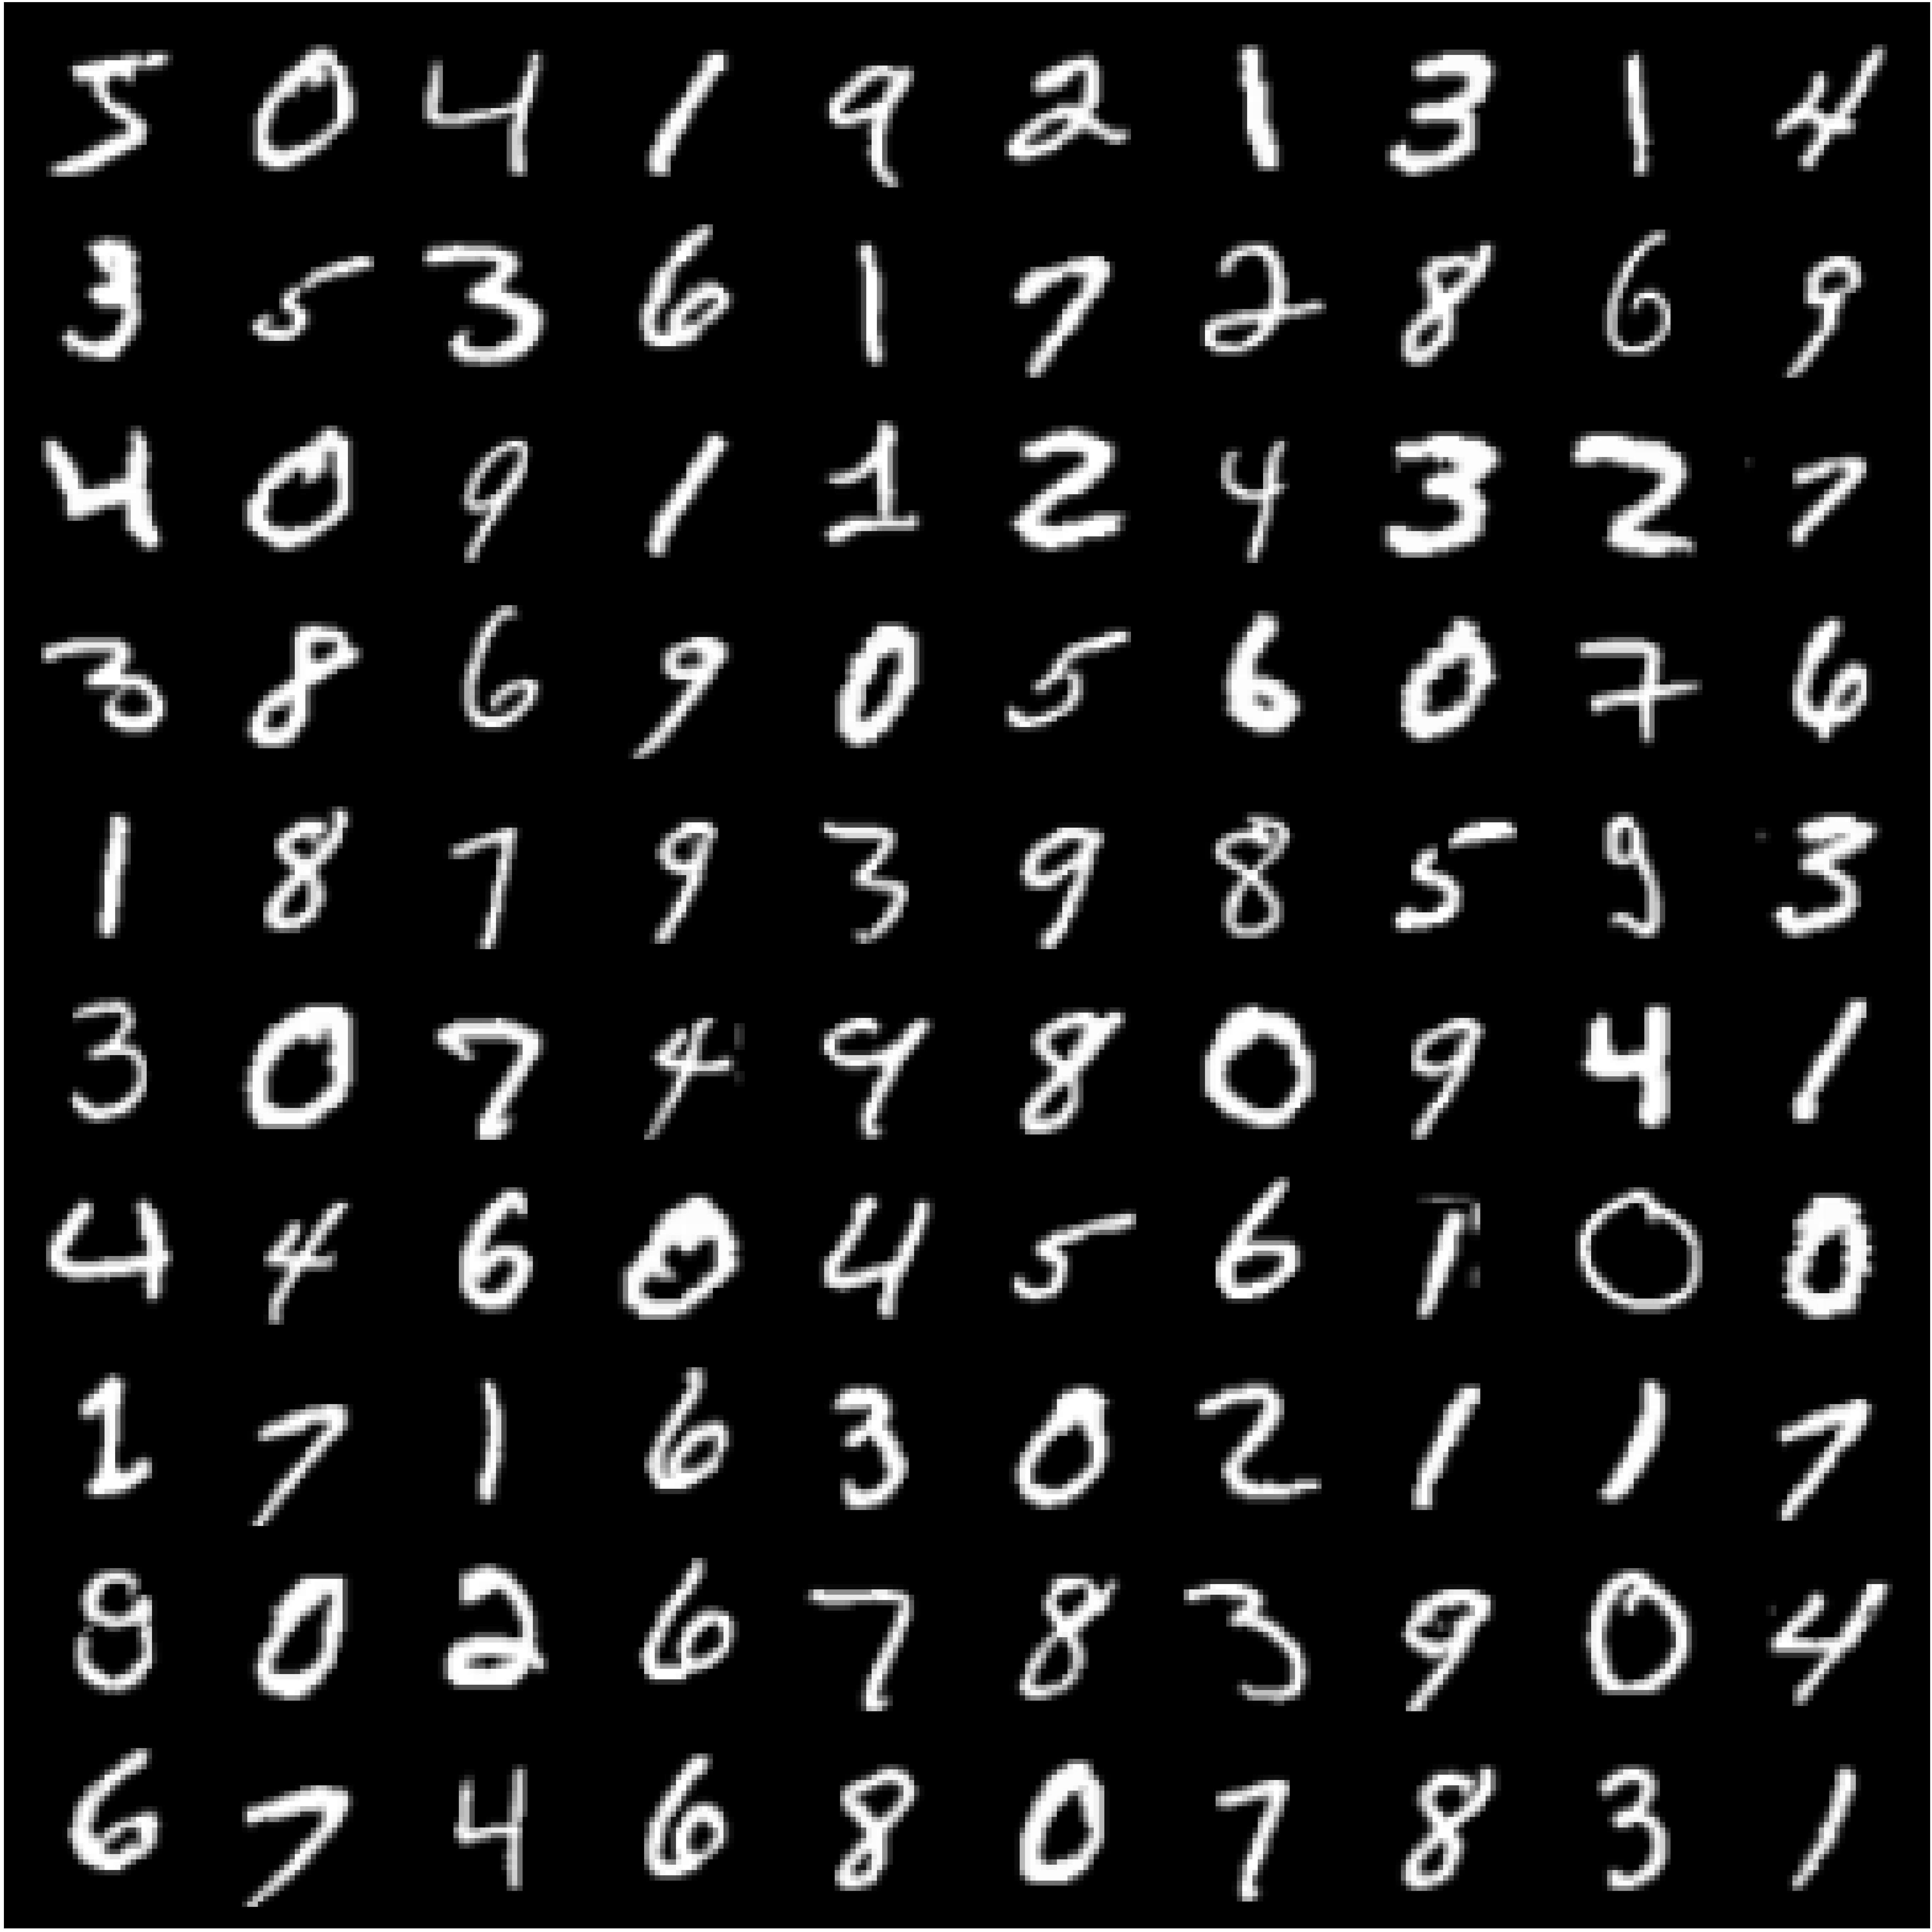

In [5]:
images = []
for i, (x,y) in enumerate(train_dataset):
    images.append(x)
    if i+1 >= 100:
        break

#images = torch.stack(images).flatten(0,1)

images = torch.stack(images)
out_grid = make_grid(images, normalize=True, nrow=10, scale_each=True, padding=int(0.125*32)).permute(1,2,0)

fig, ax = plt.subplots(1,1 ,figsize=(100, 100))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.imshow(out_grid.cpu())
plt.show()
#plt.savefig('sample_path' + '/steps_%d' %(steps))

#plot_image_grid(images, 10, 10)

# Hyper-parameters

In [6]:
n_epoch = 100
batch_size = 128
learning_rate_discriminator = 0.001
learning_rate_generator = 0.001
dim_latent = 32
dim_channel = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Networks

In [7]:
class Discriminator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=8):
        
		super(Discriminator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2
		
		self.feature = nn.Sequential(
			nn.Conv2d(in_channel, dim_feature * 1, kernel_size=3, stride=2, padding=1, bias=True),
			#nn.BatchNorm2d(dim_feature * 1),
			nn.LeakyReLU(threshold_ReLU, inplace=True),

			nn.Conv2d(dim_feature * 1, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True),
			#nn.BatchNorm2d(dim_feature * 2),
			nn.LeakyReLU(threshold_ReLU, inplace=True),

			nn.Conv2d(dim_feature * 2, dim_feature * 4, kernel_size=3, stride=2, padding=1, bias=True),
			#nn.BatchNorm2d(dim_feature * 4),
			nn.LeakyReLU(threshold_ReLU, inplace=True),

			nn.Conv2d(dim_feature * 4, dim_feature * 8, kernel_size=3, stride=2, padding=1, bias=True),
			#nn.BatchNorm2d(dim_feature * 8),
			nn.LeakyReLU(threshold_ReLU, inplace=True),

			nn.Conv2d(dim_feature * 8, dim_feature * 16, kernel_size=3, stride=2, padding=1, bias=True),
			#nn.BatchNorm2d(dim_feature * 16),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
		)	
		
		self.classifier = nn.Sequential(
			nn.Linear(dim_feature * 16, dim_feature * 8, bias=True),
			#nn.BatchNorm1d(dim_feature * 8),
			nn.LeakyReLU(threshold_ReLU, inplace=True),

			nn.Linear(dim_feature * 8, dim_feature * 4, bias=True),
			#nn.BatchNorm1d(dim_feature * 4),
			nn.LeakyReLU(threshold_ReLU, inplace=True),

			nn.Linear(dim_feature * 4, dim_feature * 2, bias=True),
			#nn.BatchNorm1d(dim_feature * 2),
			nn.LeakyReLU(threshold_ReLU, inplace=True),

			nn.Linear(dim_feature * 2, dim_feature * 1, bias=True),
			#nn.BatchNorm1d(dim_feature * 1),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			
			nn.Linear(dim_feature * 1, out_channel, bias=True),
			nn.Sigmoid()
		) 

		self.network = nn.Sequential(
			self.feature,
			nn.Flatten(),
			self.classifier,
		)

		self.initialize_weight()

	def forward(self, x):

		y = self.network.forward(x)

		return y

	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass

In [8]:
class Generator(nn.Module): 

	def __init__(self, in_channel=1, out_channel=1, dim_feature=8):
        
		super(Generator, self).__init__()

		self.in_channel 	= in_channel
		self.out_channel	= out_channel
		self.dim_feature	= dim_feature
		threshold_ReLU 		= 0.2

		self.network = nn.Sequential(
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(in_channel, dim_feature * 8, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 8),
			nn.LeakyReLU(threshold_ReLU, inplace=True),

			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 8, dim_feature * 4, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 4),
			nn.LeakyReLU(threshold_ReLU, inplace=True),

			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 4, dim_feature * 2, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 2),
			nn.LeakyReLU(threshold_ReLU, inplace=True),

			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 2, dim_feature * 1, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(dim_feature * 1),
			nn.LeakyReLU(threshold_ReLU, inplace=True),
			
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
			nn.Conv2d(dim_feature * 1, out_channel, kernel_size=3, stride=1, padding=1, bias=True),
			nn.BatchNorm2d(out_channel),
			nn.Sigmoid() # use this because MNIST values range within 0~1
		)

		self.initialize_weight()
		
	def forward(self, x):

		y = self.network.forward(x)

		return y
	
	def initialize_weight(self):
	
		print('initialize model parameters :', 'xavier_uniform')

		for m in self.network.modules():
			
			if isinstance(m, nn.Conv2d):
				
				nn.init.xavier_uniform_(m.weight)
				
				if m.bias is not None:

					nn.init.constant_(m.bias, 1)
					pass
					
			elif isinstance(m, nn.BatchNorm2d):
				
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 1)
				
			elif isinstance(m, nn.Linear):
				
				nn.init.xavier_uniform_(m.weight)

				if m.bias is not None:
					
					nn.init.constant_(m.bias, 1)
					pass


# Prepare for Training

In [9]:
# Networks
discriminator = Discriminator(in_channel=dim_channel, out_channel=1, dim_feature=32).to(device)
generator = Generator(in_channel=dim_latent, out_channel=1, dim_feature=32).to(device)

print()
print('<Architecture of Generator Network>')
summary(generator, input_size=(dim_latent, 1, 1))
print()
print('<Architecture of Discriminator Network>')
summary(discriminator, input_size=(dim_channel, 32, 32))
print()

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_generator = torch.optim.SGD(generator.parameters(), lr=learning_rate_generator)
optimizer_discriminator = torch.optim.SGD(discriminator.parameters(), lr=learning_rate_discriminator)

initialize model parameters : xavier_uniform
initialize model parameters : xavier_uniform

<Architecture of Generator Network>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1             [-1, 32, 2, 2]               0
            Conv2d-2            [-1, 256, 2, 2]          73,984
       BatchNorm2d-3            [-1, 256, 2, 2]             512
         LeakyReLU-4            [-1, 256, 2, 2]               0
          Upsample-5            [-1, 256, 4, 4]               0
            Conv2d-6            [-1, 128, 4, 4]         295,040
       BatchNorm2d-7            [-1, 128, 4, 4]             256
         LeakyReLU-8            [-1, 128, 4, 4]               0
          Upsample-9            [-1, 128, 8, 8]               0
           Conv2d-10             [-1, 64, 8, 8]          73,792
      BatchNorm2d-11             [-1, 64, 8, 8]             128
        LeakyReLU-12             [-1, 64

In [10]:
# lists for loss and prediction values to plot curves

loss_discriminator_mean = np.zeros(n_epoch)
loss_discriminator_std = np.zeros(n_epoch)
loss_generator_mean = np.zeros(n_epoch)
loss_generator_std = np.zeros(n_epoch)

prediction_real_mean = np.zeros(n_epoch) # D(x)
prediction_real_std = np.zeros(n_epoch) # D(x)
prediction_fake_mean = np.zeros(n_epoch) # D(G(z))
prediction_fake_std = np.zeros(n_epoch) # D(G(z))

# Train

<ipython-input-11-90a88afeb562>:2: RuntimeWarning: overflow encountered in exp
  lambda_ = 1 / (4 + np.exp(1/(sum_distance_d)))


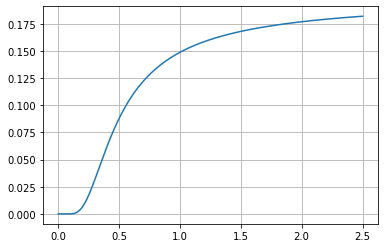

In [11]:
sum_distance_d = np.linspace(0.0001, 2.5, 1000)
lambda_ = 1 / (4 + np.exp(1/(sum_distance_d)))
plt.grid(True)
plt.plot(sum_distance_d, lambda_)
plt.show()

In [2]:
import math

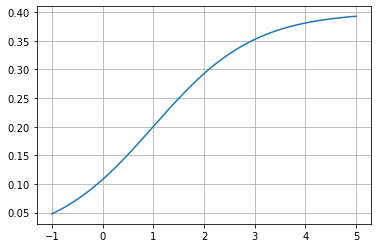

-2.2005127291668156
0.2925661903596537


In [175]:
sum_distance_d = np.linspace(-1, 5, 100000)
n = 2
a = 2*n
b = 5*n
c = np.log((3-math.sqrt(5-4*a/b)) / (2+b*(math.sqrt(5-4*a/b) - 1)))
lambda_ = a / (b + np.exp(-sum_distance_d-2*c))
plt.grid(True)
plt.plot(sum_distance_d, lambda_)
plt.show()
print(c)
print(a / (b + np.exp(-n-2*c)))

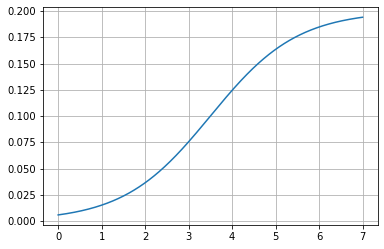

In [13]:
sum_distance_d = np.linspace(0, 7, 100000)
lambda_ = 0.2 / (1 + np.exp((-sum_distance_d+3.5)))
plt.grid(True)
plt.plot(sum_distance_d, lambda_)
plt.show()

In [23]:
# train mode on
discriminator.train()
generator.train()

for epoch in tqdm(range(n_epoch)):

    loss_discriminator_batch = []
    loss_generator_batch = []
    prediction_real_batch = []
    prediction_fake_batch = []

    for x, y in tqdm(train_loader):

        # update discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        optimizer_discriminator.zero_grad()
        # real images
        real = x.to(device)
        prediction_real = discriminator(real)
        label_real = torch.ones_like(prediction_real, device=device)
        real_loss = criterion(prediction_real, label_real)
        # fake images
        noise = torch.randn(batch_size, dim_latent, 1, 1, device=device)
        fake = generator(noise)
        prediction_fake = discriminator(fake)
        label_fake = torch.zeros_like(prediction_fake)
        fake_loss = criterion(prediction_fake, label_fake)

        loss_discriminator = (real_loss + fake_loss) / 2.0
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # update generator: maximize log(D(G(z)))
        optimizer_generator.zero_grad()
        fake = generator(noise)
        prediction_fake = discriminator(fake)
        label_real = torch.ones_like(prediction_fake)
        loss_generator = criterion(prediction_fake, label_real)
        loss_generator.backward()
        optimizer_generator.step()

        # save losses & prediction values for minibatch
        loss_discriminator_batch.append(loss_discriminator.item())
        loss_generator_batch.append(loss_generator.item())
        prediction_real_batch.append(prediction_real.mean().item())
        prediction_fake_batch.append(prediction_fake.mean().item())

    # save losses & prediction values
    loss_discriminator_mean[epoch] = np.mean(loss_discriminator_batch)
    loss_discriminator_std[epoch] = np.std(loss_discriminator_batch)
    loss_generator_mean[epoch] = np.mean(loss_generator_batch)
    loss_generator_std[epoch] = np.std(loss_generator_batch)
    prediction_real_mean[epoch] = np.mean(prediction_real_batch)
    prediction_real_std[epoch] = np.std(prediction_real_batch)
    prediction_fake_mean[epoch] = np.mean(prediction_fake_batch)
    prediction_fake_std[epoch] = np.std(prediction_fake_batch)

    print('epoch: {}/{} loss_discriminator: {:.6f} loss_generator: {:.6f} prediction_real: {:.6f} prediction_fake: {:.6f}' .format(epoch + 1, n_epoch, loss_discriminator_mean[epoch], loss_generator_mean[epoch], prediction_real_mean[epoch], prediction_fake_mean[epoch]))

  1%|          | 1/100 [00:41<1:09:13, 41.96s/it]

epoch: 1/100 loss_discriminator: 0.609553 loss_generator: 0.928444 prediction_real: 0.575004 prediction_fake: 0.420204


  1%|          | 1/100 [00:53<1:27:30, 53.04s/it]


KeyboardInterrupt: 

# Plot Result

In [15]:
generator.eval()
discriminator.eval()
print()

In [16]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title, filename=None):

    fig = plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

In [17]:
def plot_curve_error2(data1_mean, data1_std, data1_label, data2_mean, data2_std, data2_label, x_label, y_label, title, filename=None):
    
    fig = plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3

    plt.plot(range(len(data1_mean)), data1_mean, '-', color = 'blue', label = data1_label)
    plt.fill_between(range(len(data1_mean)), data1_mean - data1_std, data1_mean + data1_std, facecolor = 'blue', alpha = alpha)

    plt.plot(range(len(data2_mean)), data2_mean, '-', color = 'red', label = data2_label)
    plt.fill_between(range(len(data2_mean)), data2_mean - data2_std, data2_mean + data2_std, facecolor = 'red', alpha = alpha)

    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

    if filename is not None:

        fig.savefig(filename)
        pass

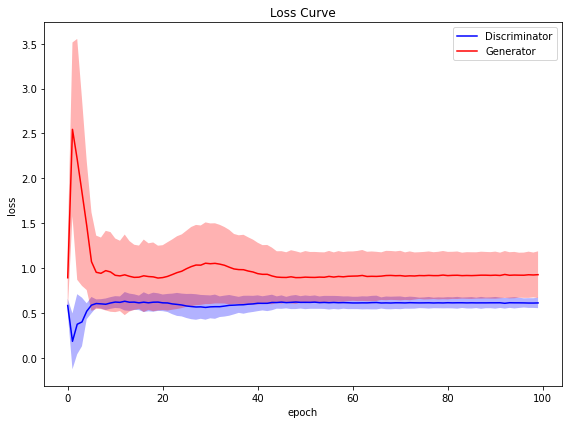

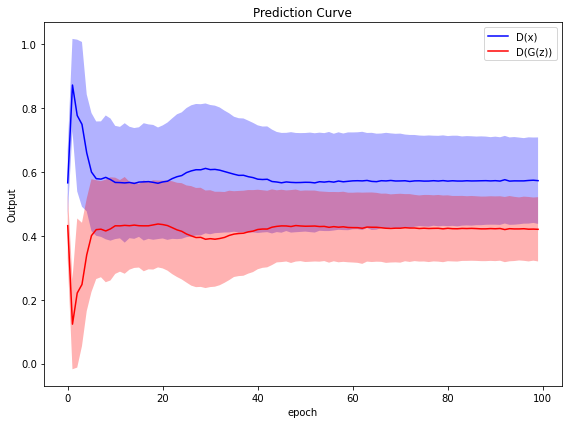

In [18]:
plot_curve_error2(loss_discriminator_mean, loss_discriminator_std, 'Discriminator', loss_generator_mean, loss_generator_std, 'Generator', 'epoch', 'loss', 'Loss Curve')
plot_curve_error2(prediction_real_mean, prediction_real_std, 'D(x)', prediction_fake_mean, prediction_fake_std, 'D(G(z))', 'epoch', 'Output', 'Prediction Curve')

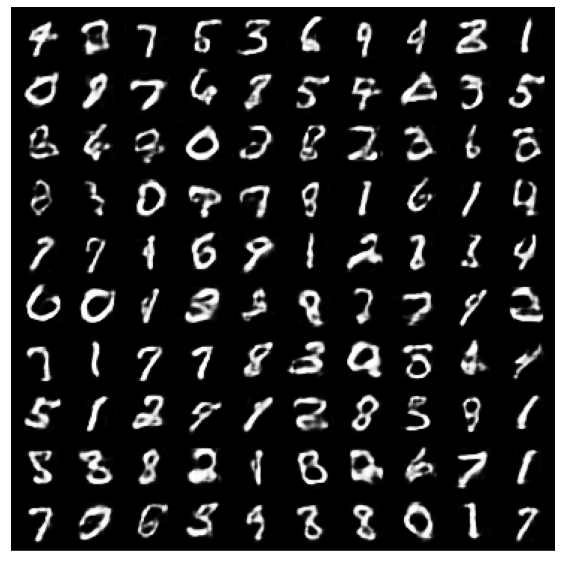

In [21]:
# generate test images
noise = torch.randn(100, dim_latent, 1, 1, device=device)
generated_images = generator(noise)

# plot_image_grid(generated_images, 10, 10)


out_grid = make_grid(generated_images, normalize=True, nrow=10, scale_each=True, padding=int(0.125*32)).permute(1,2,0)

fig, ax = plt.subplots(1,1 ,figsize=(10, 10))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.imshow(out_grid.cpu())
plt.show()